# Model Training

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
mdf = pd.read_csv("../data/processed/pop_train_encoded_.csv") 

X = mdf.drop(['status_group','gps_height_bin','lat_lon_bin'], axis=1) #'id',
y = mdf['status_group']

In [25]:
X.shape

(59400, 21)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=None,  # Not used for multiclass directly
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train, sample_weight=[class_weights[i] for i in y_train])

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost F1 Macro:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 Macro: 0.6549619084673375
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      4565
           1       0.30      0.69      0.42       863
           2       0.83      0.74      0.78      6452

    accuracy                           0.73     11880
   macro avg       0.65      0.72      0.65     11880
weighted avg       0.78      0.73      0.75     11880



In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 2]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    scoring='f1_macro',
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
print("Tuned XGBoost F1 Macro:", f1_score(y_test, y_pred, average='macro'))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:09:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:09:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:09:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:09:47] WARNING: /Users/runner/work/xgbo

Tuned XGBoost F1 Macro: 0.6671184614977661


In [30]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weight_dict = dict(zip(classes, weights))
sample_weights = [weight_dict[i] for i in y_train]

search.fit(X_train, y_train, sample_weight=sample_weights)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:10:14] WARNING: /Users/runner/work/xgbo

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='f1_macro', verbose=1)

In [31]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
print("Weighted Tuned XGBoost F1 Macro:", f1_score(y_test, y_pred, average='macro'))

Weighted Tuned XGBoost F1 Macro: 0.6438962804565347


Results of ("../data/processed/imputed_cleaned_feature_evl.csv") 

XGBoost F1 Macro: 0.6619259459998141
Tuned XGBoost F1 Macro: 0.677757288798658
Weighted Tuned XGBoost F1 Macro: 0.6778373712960385


              precision    recall  f1-score   support

           0       0.83      0.74      0.78      4565
           1       0.83      0.76      0.79      6452
           2       0.30      0.67      0.42       863

    accuracy                           0.74     11880
   macro avg       0.65      0.72      0.66     11880
weighted avg       0.79      0.74      0.76     11880

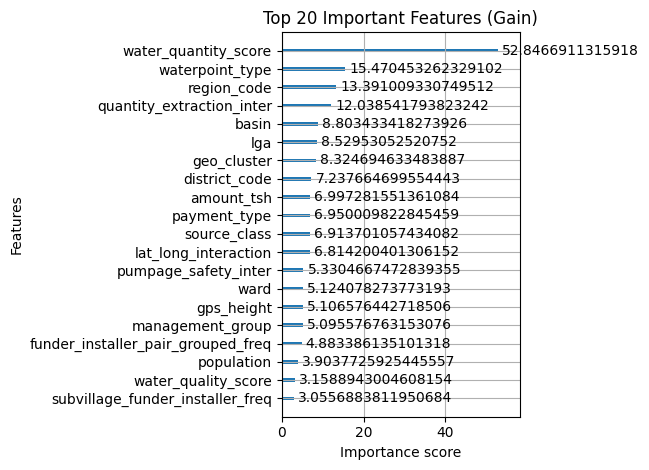

In [32]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()

In [11]:
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, score in sorted_importance[:10]:
    print(f"{feature}: {score}")


quantity_score: 55.92546081542969
extraction_type: 17.488767623901367
region_code: 12.863322257995605
pump_age: 11.814208030700684
basin: 11.62908935546875
waterpoint_type: 11.5723876953125
lga: 9.87529468536377
source: 9.62923812866211
amount_tsh: 7.996463775634766
management: 7.641648769378662


In [12]:
feature_names = X_train.columns  # or use get_feature_names_out() if transformed

 98%|===================| 2934/3000 [00:37<00:00]        

SHAP values shape: (1000, 21, 3)

Generating SHAP summary for: Class 0 - Non Functional


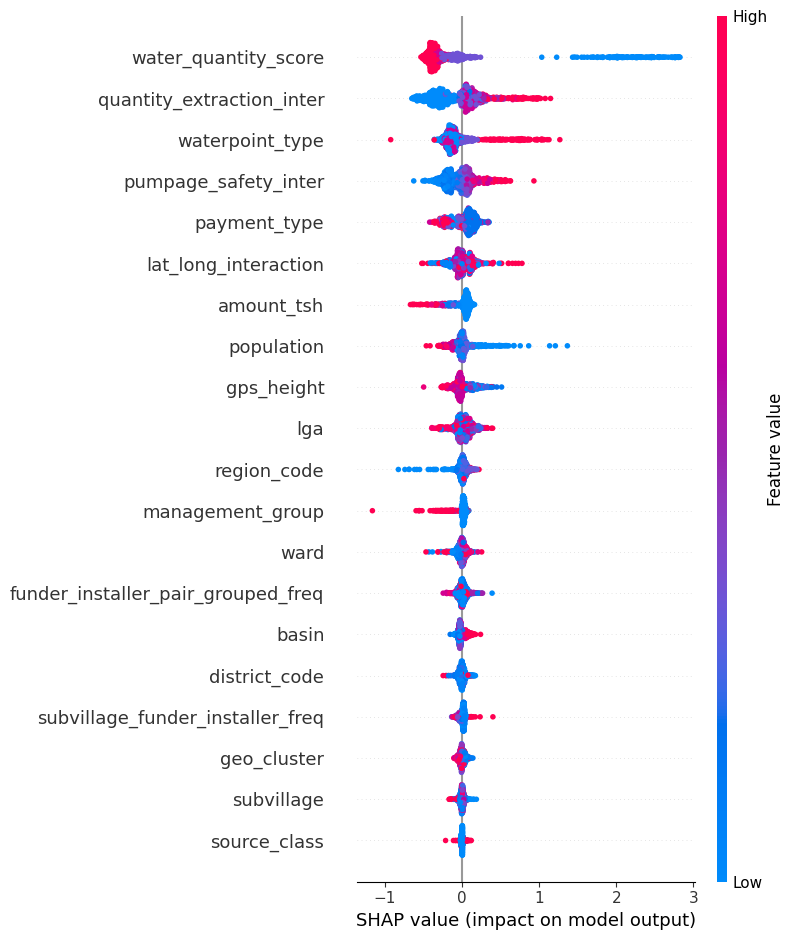


Generating SHAP summary for: Class 1 - Needs Repair


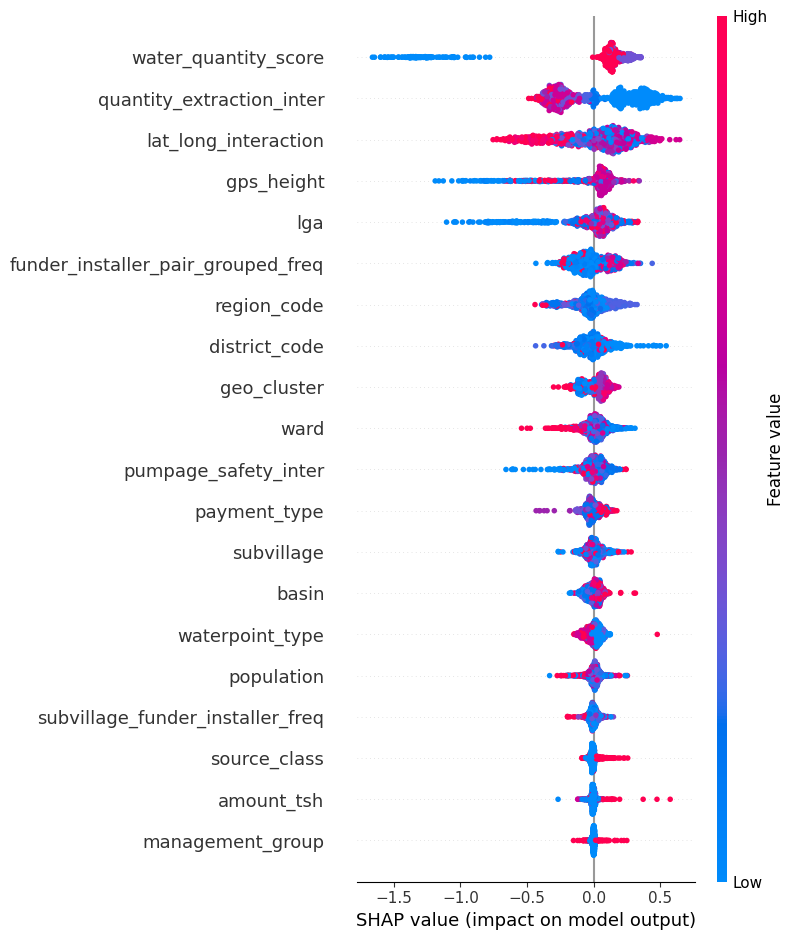


Generating SHAP summary for: Class 2 - Functional


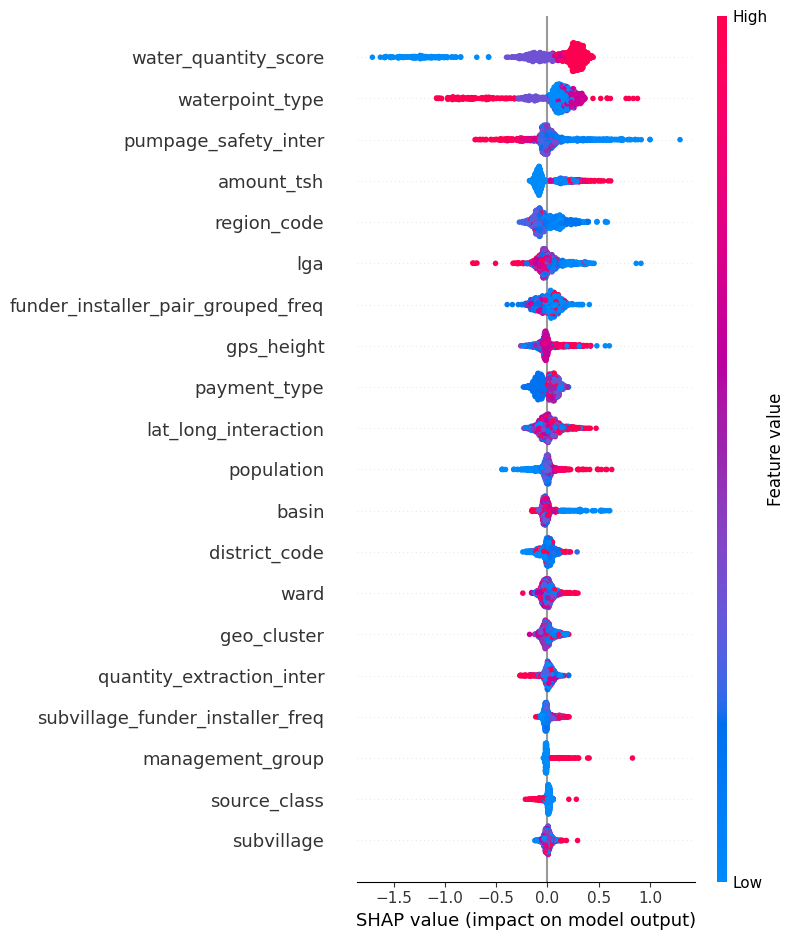

In [33]:
import shap
import matplotlib.pyplot as plt

# Sample data for SHAP explanation
X_sample = X_train if len(X_train) < 1000 else X_train.sample(1000, random_state=42)

# Use new SHAP explainer
explainer = shap.Explainer(best_model, X_sample)

# Compute SHAP values (Shape: [samples, features, classes])
shap_values = explainer(X_sample)

# Confirm shape
print("SHAP values shape:", shap_values.values.shape)  # Should be [1000, num_features, 3]

# Class names (you can customize)
class_names = ['Class 0 - Non Functional', 'Class 1 - Needs Repair', 'Class 2 - Functional']

# Plot beeswarm for each class
for i in range(shap_values.values.shape[2]):
    print(f"\nGenerating SHAP summary for: {class_names[i]}")
    shap.summary_plot(shap_values.values[:, :, i], X_sample, show=True)


In [ ]:
print(f"Type of shap_values: {type(shap_values)}")
print(f"Length of shap_values: {len(shap_values)}")
for i, s in enumerate(shap_values):
    print(f"Class {i} SHAP shape: {s.shape}, Sample shape: {X_sample.shape}")

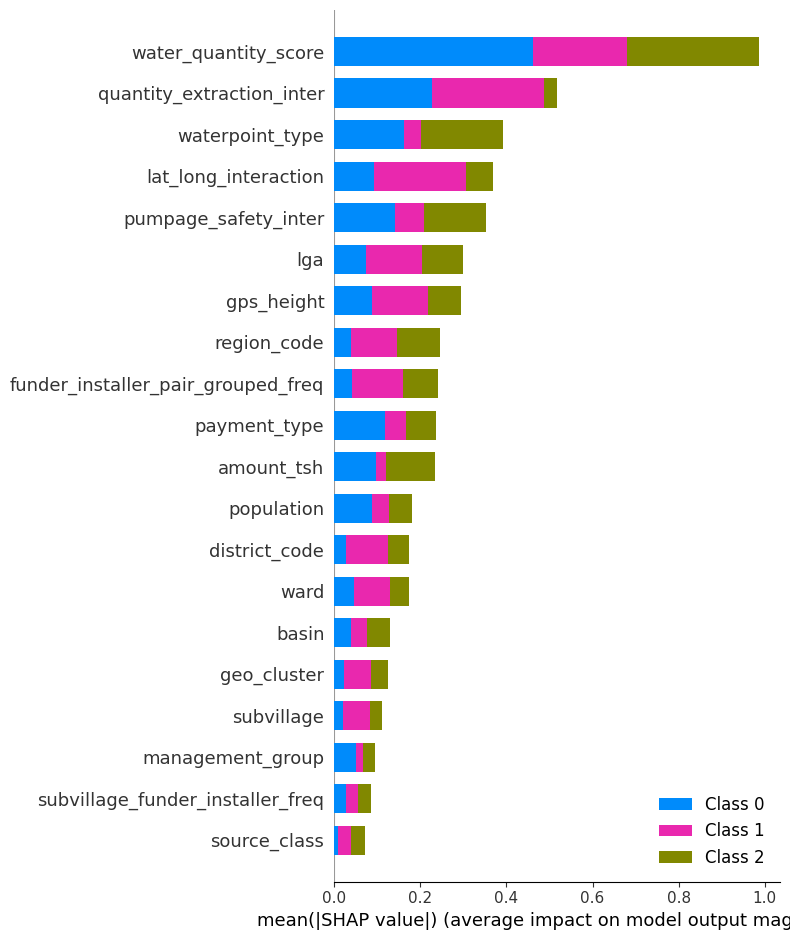

In [35]:
import shap
import matplotlib.pyplot as plt

# Use a sample if your data is large
X_sample = X_train if len(X_train) < 1000 else X_train.sample(1000, random_state=42)

# Create SHAP explainer (for tree-based models)
explainer = shap.Explainer(best_model)  # Or shap.TreeExplainer(xgb_model)
shap_values = explainer(X_sample)

# Plot summary of all features
shap.summary_plot(shap_values, X_sample)

In [ ]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

In [36]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [42]:
top_features = ["water_quantity_score", "quantity_extraction_inter","lat_long_interaction","lga", "gps_height","waterpoint_type"]

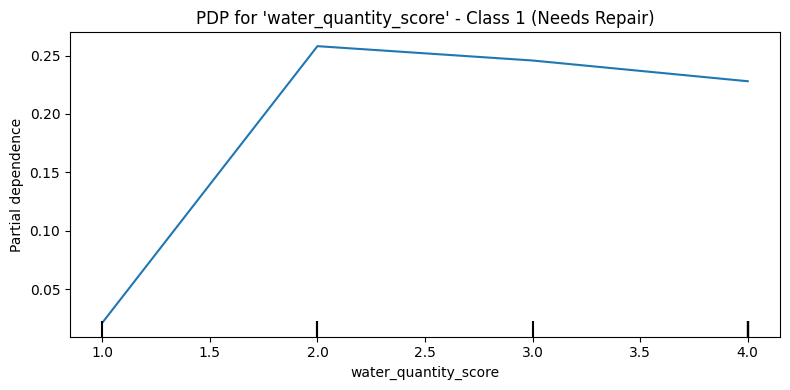

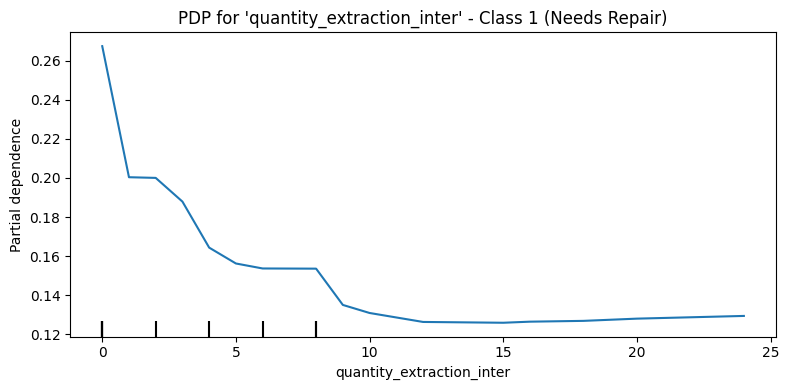

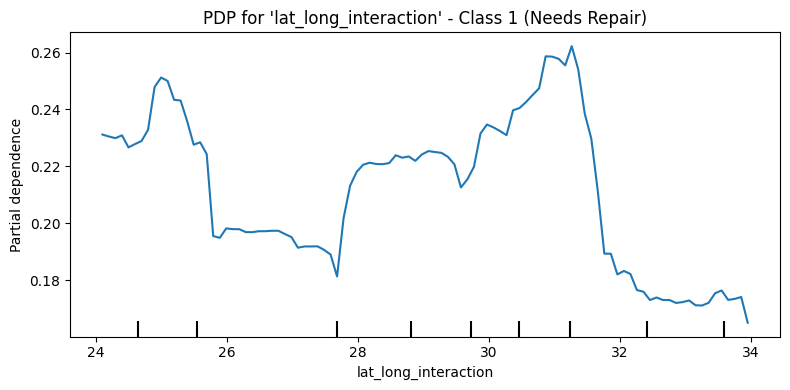

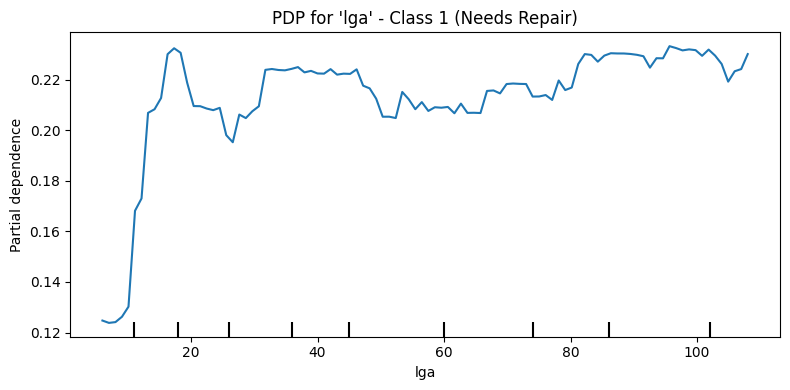

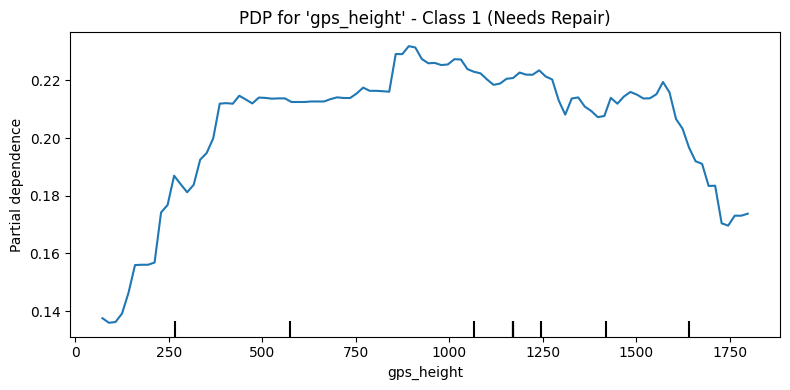

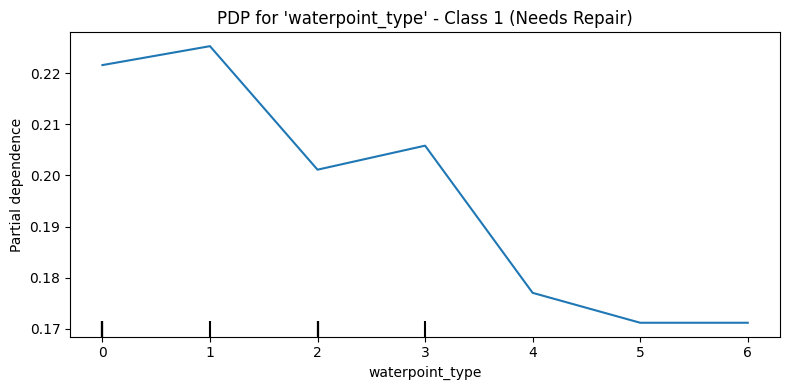

In [46]:
# If using sklearn-compatible model (like XGBClassifier from sklearn wrapper)
for feature in top_features:
    fig, ax = plt.subplots(figsize=(8, 4))
    display = PartialDependenceDisplay.from_estimator(
        best_model,           # Your trained model
        X_train,              # Full training data
        features=[feature],   # Feature to analyze
        target=1,             # Class index (0 = Non Functional, etc.)
        ax=ax
    )
    ax.set_title(f"PDP for '{feature}' - Class 1 (Needs Repair)")
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', random_forest_model),
        ('cb', catboost_model),
        ('xgb', best_model)
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
print("Ensemble F1 Macro:", f1_score(y_test, y_pred, average='macro'))
